In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from itertools import product

In [15]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the figure suptitle
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
def plot_training_curves(train_losses, test_losses, train_mees, test_mees, hyperparams):
    """
    Plot training and test curves for loss and Mean Euclidean Error (MEE).

    Parameters:
    - epoch (int): The total number of training epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_mees (list): List of training MEE values for each epoch.
    - test_mees (list): List of test MEE values for each epoch.
    - hyperparams (list): List of hyperparameters used for the plot.

    Returns:
    None

    Plots four subplots:
    1. Training and test loss curves.
    2. Training and test MEE curves.
    3. Zoomed-in training and test loss curves with y-axis limit [0, 10].
    4. Zoomed-in training and test MEE curves with y-axis limit [0, 10].

    The hyperparameters are used in the plot title to provide additional context.
    """

    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Batch Size={hyperparams[3]},Activation Function={hyperparams[5]}, Layers={hyperparams[6]} Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}, dropout = {hyperparams[7]}')
    # Loss plots
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss', color = 'red')
    plt.plot(test_losses, label='Validation Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    # MEE plots
    plt.subplot(2, 2, 2)
    plt.plot(train_mees, label='Training MEE', color='red')
    plt.plot(test_mees, label='Validation MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.legend()

    # Loss plots
    plt.subplot(2, 2, 3)
    plt.plot(train_losses, label='Training Loss', color = 'red')
    plt.plot(test_losses, label='Validation Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.ylim(0,10)
    plt.legend()

    # MEE plots
    plt.subplot(2, 2, 4)
    plt.plot(train_mees, label='Training MEE', color='red')
    plt.plot(test_mees, label='Validation MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.ylim(0,10)
    plt.legend()

    plt.tight_layout()

    plt.show()

In [18]:
def mean_euclidean_error(tensor1, tensor2):
    """
    Compute the mean Euclidean error between two sets of 3D vectors.

    Parameters:
    - tensor1: PyTorch tensor of size (N, 3) representing the first set of 3D vectors
    - tensor2: PyTorch tensor of size (N, 3) representing the second set of 3D vectors

    Returns:
    - mean_error: Mean Euclidean error between the two sets of vectors
    """
    # Check if the tensors have the correct shape
    if tensor1.shape[1] != 3 or tensor2.shape[1] != 3 or tensor1.shape[0] != tensor2.shape[0]:
        raise ValueError("Input tensors must be of size (N, 3)")


    # Compute Euclidean distance
    euclidean_distance = torch.norm(tensor1 - tensor2, dim=1)

    # Calculate the mean Euclidean error
    mean_error = torch.mean(euclidean_distance)

    return mean_error.item()

In [19]:
# Define a regression eural network

class RegressorNN(nn.Module):
    def __init__(self, hidden_size, activation_function, num_layers, dropout_prob, input_size=10, output_size=3):
        super(RegressorNN, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, hidden_size)]

        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(activation_function)
            self.layers.append(nn.Dropout(p=dropout_prob))  # Add dropout layer

        # Output layer
        self.layers.append(nn.Linear(hidden_size, output_size))

        # Create a Sequential container for the layers
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

In [20]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

def training_model(x_train, y_train, x_test, y_test, neuron_number,learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor, lr_patience, optimiz, num_epochs=1000, plot_curves=False, return_history=False):
    """
    Train the regression model and evaluate it on a test (can also be validation, depending on the context).

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test input data.
    - y_test (torch.Tensor): Test target data.
    - neuron_number (int): Total number of neurons across all layers.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - bs (int): Batch size for training.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - activation (torch.nn.Module): Activation function for the model.
    - layers (int): Number of hidden layers in the model.
    - num_epochs (int, optional): Number of training epochs (default: 1000).
    - plot_curves (bool, optional): Whether to plot training curves (default: False).

    Returns:
    - tuple: Tuple containing the number of epochs, final training loss, final test loss, final training MEE, and final test MEE.

    The function trains a neural network regression model using the specified hyperparameters and evaluates its performance on the test set.
    """

    hidden_size = int(neuron_number/layers)
    #print(hidden_size)
    # Create an instance of the model
    model = RegressorNN(hidden_size=hidden_size, dropout_prob=dropout, activation_function=activation, num_layers=layers)
    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    if optimiz == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)
    if optimiz == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_coeff)
    if optimiz == 'RMS':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    # Set the initial learning rate and create a learning rate scheduler
    initial_lr = learning_rate
    #scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Adjust step_size and gamma as needed
    #scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=lr_patience, verbose=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_patience, gamma=factor, verbose=True)
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

    # Lists to store training and test losses for plotting
    train_losses, test_losses, train_mees, test_mees = [], [], [], []

    # parameters to stop at training convergence
    min_mee = float('inf')
    patience_counter, patience = 0, 20

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels) #Compute the loss

            optimizer.zero_grad()   # Zero the gradients
            loss.backward() # Backward pass
            optimizer.step()  # Update weights

        model.eval()  # Set the model to evaluation mode
        #calculate loss
        y_pred = model(x_train)
        train_loss = criterion(y_pred, y_train)
        # Calculate mee
        train_mee = mean_euclidean_error(y_pred,y_train)
        train_losses.append(train_loss.item())
        train_mees.append(train_mee)

        # Evaluation on the test/validation set
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

            # Calculate test mee
            test_mee = mean_euclidean_error(test_outputs,y_test)
            test_mees.append(test_mee)
            test_losses.append(test_loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}],Learning Rate: {optimizer.param_groups[0]["lr"]}, Loss: {train_loss.item():.4f}, '
            f'MEE: {train_mee:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} MEE: {test_mee:.4f} ', end='\r')


        # Check for convergence
        if train_mee < min_mee and abs(train_mee-min_mee)>1e-3:
            patience_counter = 0
            min_mee = train_mee
        else:
            patience_counter += 1

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break


        # Update the learning rate using the scheduler
        scheduler.step()

    print(f'N. Epochs = {epoch+1} - Loss (train | test/val )= ({train_loss.item():.4} | {test_loss.item():.4} ) - MEE (train | test/val ) = ({train_mee:.4} | {test_mee:.4} )')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor,lr_patience, num_epochs]
        plot_training_curves(train_losses, test_losses, train_mees, test_mees, hyperparams)

    if return_history:
        return model, epoch+1, train_loss.item(), test_loss.item(), train_mee, test_mee, np.array(train_losses), np.array(test_losses), np.array(train_mees), np.array(test_mees)
    else:
        return model, epoch+1, train_loss.item(), test_loss.item(), train_mee, test_mee

In [21]:
def reshape_history(N,hist):
    min_len = float('inf')
    for i in range(0,N):
        #print(len(train_losses_hist[i]))
        if len(hist[i]) < min_len:
            min_len = len(hist[i])

    for i in range(0,N):
        hist[i]=hist[i][:min_len]

    return hist

def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         neuron_number,learning_rate, momentum,
                                         bs, reg_coeff, activation,layers, dropout, factor, lr_patience,optimiz, max_num_epochs=1000,
                                         plot_curves=False, N = 5, return_history=False):
    """
    Train the model multiple times with different weight initializations to estimate performance mean and variance.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test input data.
    - y_test (torch.Tensor): Test target data.
    - neuron_number (int): Total number of neurons across all layers.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - bs (int): Batch size for training.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - activation (torch.nn.Module): Activation function for the model.
    - layers (int): Number of hidden layers in the model.
    - num_epochs (int, optional): Number of training epochs (default: 1000).
    - plot_curves (bool, optional): Whether to plot training curves (default: False).
    - N (int, optional): Number of times to train the model with different initializations (default: 5).

    Returns:
    None

    Prints the mean and standard deviation of training and test loss, as well as training and test Mean Euclidean Error (MEE).
    """
    final_train_loss = []
    final_test_loss = []
    final_train_mee = []
    final_test_mee = []
    train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist = [[] for _ in range(N)],  [[] for _ in range(N)],  [[] for _ in range(N)],  [[] for _ in range(N)]
    models = []
    for i in range (0,N):
        #print(f'\n initialization {i+1}/{N}')
        model , num_epochs,train_loss, test_loss, train_mee, test_mee, train_losses_hist[i], test_losses_hist[i], train_mees_hist[i], test_mees_hist[i] = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        neuron_number,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        activation,
                        layers,
                        dropout,
                        factor,
                        lr_patience,
                        optimiz,
                        plot_curves=False,
                        num_epochs=max_num_epochs,
                        return_history=True)


        final_train_loss.append(train_loss)
        final_test_loss.append(test_loss)
        final_train_mee.append(train_mee)
        final_test_mee.append(test_mee)
        models.append(model)

    if plot_curves:
        hyperparams = [int(neuron_number/layers),learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, num_epochs]
        plot_training_curves(train_losses=train_losses_hist[i],test_losses=test_losses_hist[i],train_mees=train_mees_hist[i],test_mees=test_mees_hist[i],hyperparams=hyperparams)

    plt.show()
    print(f'Avg of {N} initializations: Loss (train | test/val )= ({np.mean(final_train_loss):.4} +- {np.std(final_train_loss):.4} | {np.mean(final_test_loss):.4} +- {np.std(final_test_loss):.4})'
          f'- MEE (train | test/val ) = ( {np.mean(final_train_mee):.4} +-  {np.std(final_train_mee):.4} | {np.mean(final_test_mee):.4} +- {np.std(final_test_mee):.4})')


    if return_history:
        train_losses_hist = reshape_history(N,train_losses_hist)
        test_losses_hist = reshape_history(N,test_losses_hist)
        train_mees_hist = reshape_history(N,train_mees_hist)
        test_mees_hist = reshape_history(N,test_mees_hist)
        return models, train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist
    else:
        return np.mean(final_train_loss), np.mean(final_test_loss), np.mean(final_train_mee), np.mean(final_test_mee)

In [22]:
def perform_grid_search_kfold(neuron_numbers, learning_rates, momentums, batch_sizes, reg_coeffs, activations, layerss, dropouts,factors, lr_patiences, optimiz, k_folds, x, y, plot_curves=False, num_epochs=1000, number_of_init=5):
    """
    Perform grid search with k-fold cross-validation for hyperparameters.

    Parameters:
    - neuron_numbers (list): List of neuron numbers to search.
    - learning_rates (list): List of learning rates to search.
    - momentums (list): List of momentum values to search.
    - batch_sizes (list): List of batch sizes to search.
    - reg_coeffs (list): List of regularization coefficients to search.
    - activations (list): List of activation functions to search.
    - layerss (list): List of numbers of hidden layers to search.
    - k_folds (int): Number of folds for cross-validation.
    - x (numpy.ndarray): Input data.
    - y (numpy.ndarray): Target data.
    - plot_curves (bool, optional): Whether to plot training curves (default: False).
    - num_epochs (int, optional): Number of training epochs (default: 1000).

    Returns:
    - list: List of best hyperparameters.

    The function performs grid search with k-fold cross-validation for Monk classifier hyperparameters and returns the best hyperparameters.
    """

    best_mee = float('inf')
    best_hyperparams = []

    for neuron_number, learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor,lr_patience in product(neuron_numbers,learning_rates,momentums,batch_sizes, reg_coeffs, activations, layerss, dropouts, factors, lr_patiences):
        print(f'activation={activation}; layers={layers}; neuron_number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}; optim = {optimiz}; factor={factor};lr_patience={lr_patience}')

        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and MEEs for each epoch
        train_losses, val_losses, train_mees, val_mees = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            train_loss, val_loss, train_mee, val_mee = train_with_different_initializations(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                neuron_number=neuron_number, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, activation=activation, layers=layers,dropout=dropout,factor=factor, lr_patience=lr_patience, optimiz=optimiz ,plot_curves=plot_curves, max_num_epochs=num_epochs, N=number_of_init)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_mees.append(train_mee)
            val_mees.append(val_mee)

        print(f'Final Results: activation={activation}; layers={layers}; neuron number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_mee = {np.mean(train_mees):.4} +- {np.std(train_mees):.4} | '
            f'val_mee = {np.mean(val_mees):.4} +- {np.std(val_mees):.4}')

        if np.mean(val_mees) < best_mee:

            best_mee = np.mean(val_mees)
            best_hyperparams = [neuron_number, learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor, lr_patience]

    print(best_hyperparams,'n Best val MEE:',best_mee)
    return best_hyperparams

In [23]:
def plot_mean_std(N,train_hist, test_hist,label):
    mean_tr = np.array(train_hist).mean(axis=0)
    std_tr = np.array(train_hist).std(axis=0)
    mean_te = np.array(test_hist).mean(axis=0)
    std_te = np.array(test_hist).std(axis=0)

    plt.figure(figsize=(9, 8))
    plt.subplot(2,1,1)
    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'maroon', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr,  color='lightcoral', alpha=0.5)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='cadetblue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.legend()

    plt.subplot(2,1,2)

    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'maroon', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr, color='lightcoral', alpha=0.5)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='cadetblue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.ylim(0,5)
    plt.legend()
    plt.show()


# IMPORT THE DATASET

In [24]:
from sklearn.model_selection import train_test_split
# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X = X.to(device)
y = y.to(device)

# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PERFORM GRID SEARCH TO FIND BEST HYPERPARAMETERS

In [25]:
'''
#study of the effect of activation function
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-4]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh(),nn.ReLU()]
layerss = [3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'
'''

'''
#study of the effect of regularization
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-4]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-2,1e-3,1e-4,1e-5]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'
'''



'''
hidden_neurons = [100,1000] #total number of neurons
learning_rates = [1e-4,1e-5]
momentums = [0.5,0.8] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [1,2,3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'
'''

'''
hidden_neurons = [1000,2000,3000] #total number of neurons
learning_rates = [1e-4]
momentums = [0.7,0.8,0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'
'''

'''
hidden_neurons = [100,1000] #total number of neurons
learning_rates = [1e-4,1e-5]
momentums = [0] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [1,2,3]
dropouts = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam'
'''

'''
hidden_neurons = [1000,2000,3000] #total number of neurons
learning_rates = [1e-4]
momentums = [0] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam'
'''


hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-5]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'RMS' #either 'SGD' or 'Adam'
factors = [0.9]
lr_patiences = [10]

#[1000, 0.0001, 0, 128, 0.001, Tanh(), 3, 0, 0.7, 20] n Best val MEE: 0.7188452879587809



best_hp = perform_grid_search_kfold(hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    factors,
                                    lr_patiences,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    number_of_init=3,
                                    plot_curves=False)

activation=Tanh(); layers=3; neuron_number=1000; lr=1e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMS; factor=0.9;lr_patience=10
Adjusting learning rate of group 0 to 1.0000e-05.
Adjusting learning rate of group 0 to 1.0000e-05.74, MEE: 43.0643 | Test - Epoch [1/5000], Loss: 705.5622 MEE: 40.9209 
Adjusting learning rate of group 0 to 1.0000e-05.33, MEE: 42.0315 | Test - Epoch [2/5000], Loss: 674.7172 MEE: 39.8879 
Adjusting learning rate of group 0 to 1.0000e-05.12, MEE: 40.7568 | Test - Epoch [3/5000], Loss: 636.9150 MEE: 38.6149 
Adjusting learning rate of group 0 to 1.0000e-05.85, MEE: 39.4106 | Test - Epoch [4/5000], Loss: 597.7170 MEE: 37.2769 
Adjusting learning rate of group 0 to 1.0000e-05.99, MEE: 38.1868 | Test - Epoch [5/5000], Loss: 563.8484 MEE: 36.0669 
Adjusting learning rate of group 0 to 1.0000e-05.41, MEE: 37.1572 | Test - Epoch [6/5000], Loss: 537.2026 MEE: 35.0604 
Adjusting learning rate of group 0 to 1.0000e-05.54, MEE: 36.3111 | Test - Epoch [7/5

Adjusting learning rate of group 0 to 9.0000e-06.920, MEE: 33.1513 | Test - Epoch [14/5000], Loss: 442.9654 MEE: 31.1783 
Adjusting learning rate of group 0 to 9.0000e-06.667, MEE: 32.8839 | Test - Epoch [15/5000], Loss: 436.7638 MEE: 30.9193 
Adjusting learning rate of group 0 to 9.0000e-06.883, MEE: 32.6340 | Test - Epoch [16/5000], Loss: 430.9532 MEE: 30.6762 
Adjusting learning rate of group 0 to 9.0000e-06.401, MEE: 32.3994 | Test - Epoch [17/5000], Loss: 425.5414 MEE: 30.4479 
Adjusting learning rate of group 0 to 9.0000e-06.346, MEE: 32.1720 | Test - Epoch [18/5000], Loss: 420.4535 MEE: 30.2267 
Adjusting learning rate of group 0 to 9.0000e-06.082, MEE: 31.9562 | Test - Epoch [19/5000], Loss: 415.6021 MEE: 30.0170 
Adjusting learning rate of group 0 to 8.1000e-06.577, MEE: 31.7535 | Test - Epoch [20/5000], Loss: 410.9973 MEE: 29.8197 
Adjusting learning rate of group 0 to 8.1000e-06..4095, MEE: 31.5790 | Test - Epoch [21/5000], Loss: 407.0413 MEE: 29.6494 
Adjusting learning rat

# TRAIN THE FINAL MODEL ON ALL THE TRAINING SET

In [26]:

hidden_neurons = [1000] #total number of neurons
learning_rates = [3e-5]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'RMS' #either 'SGD' or 'Adam' or 'RMS
factors = [0.7]
lr_patiences = [10]




best_hp = perform_grid_search_kfold(hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    factors,
                                    lr_patiences,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    number_of_init=3,
                                    plot_curves=False)

activation=Tanh(); layers=3; neuron_number=1000; lr=3e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMS; factor=0.7;lr_patience=10
Adjusting learning rate of group 0 to 3.0000e-05.
Adjusting learning rate of group 0 to 3.0000e-05.87, MEE: 41.5661 | Test - Epoch [1/5000], Loss: 661.4840 MEE: 39.4373 
Adjusting learning rate of group 0 to 3.0000e-05.05, MEE: 37.7286 | Test - Epoch [2/5000], Loss: 555.9404 MEE: 35.6162 
Adjusting learning rate of group 0 to 3.0000e-05.48, MEE: 34.6331 | Test - Epoch [3/5000], Loss: 481.4591 MEE: 32.5554 
Adjusting learning rate of group 0 to 3.0000e-05.43, MEE: 32.5430 | Test - Epoch [4/5000], Loss: 434.6885 MEE: 30.5050 
Adjusting learning rate of group 0 to 3.0000e-05.20, MEE: 31.0657 | Test - Epoch [5/5000], Loss: 400.1183 MEE: 29.0749 
Adjusting learning rate of group 0 to 3.0000e-05.56, MEE: 29.8825 | Test - Epoch [6/5000], Loss: 372.3890 MEE: 27.9139 
Adjusting learning rate of group 0 to 3.0000e-05.70, MEE: 28.8808 | Test - Epoch [7/5

Adjusting learning rate of group 0 to 3.0000e-05.
Adjusting learning rate of group 0 to 3.0000e-05.76, MEE: 39.3738 | Test - Epoch [1/5000], Loss: 668.0714 MEE: 39.4882 


Adjusting learning rate of group 0 to 3.0000e-05.69, MEE: 34.4316 | Test - Epoch [2/5000], Loss: 533.9158 MEE: 34.5499 
Adjusting learning rate of group 0 to 3.0000e-05.67, MEE: 31.7680 | Test - Epoch [3/5000], Loss: 464.9909 MEE: 31.8451 
Adjusting learning rate of group 0 to 3.0000e-05.87, MEE: 29.8731 | Test - Epoch [4/5000], Loss: 417.4465 MEE: 29.9532 
Adjusting learning rate of group 0 to 3.0000e-05.42, MEE: 28.4092 | Test - Epoch [5/5000], Loss: 382.3874 MEE: 28.5035 
Adjusting learning rate of group 0 to 3.0000e-05.97, MEE: 27.2606 | Test - Epoch [6/5000], Loss: 354.8429 MEE: 27.3616 
Adjusting learning rate of group 0 to 3.0000e-05.93, MEE: 26.3078 | Test - Epoch [7/5000], Loss: 332.7068 MEE: 26.4203 
Adjusting learning rate of group 0 to 3.0000e-05.91, MEE: 25.5003 | Test - Epoch [8/5000], Loss: 314.3693 MEE: 25.6244 
Adjusting learning rate of group 0 to 3.0000e-05.05, MEE: 24.7765 | Test - Epoch [9/5000], Loss: 298.1831 MEE: 24.9062 
Adjusting learning rate of group 0 to 2.

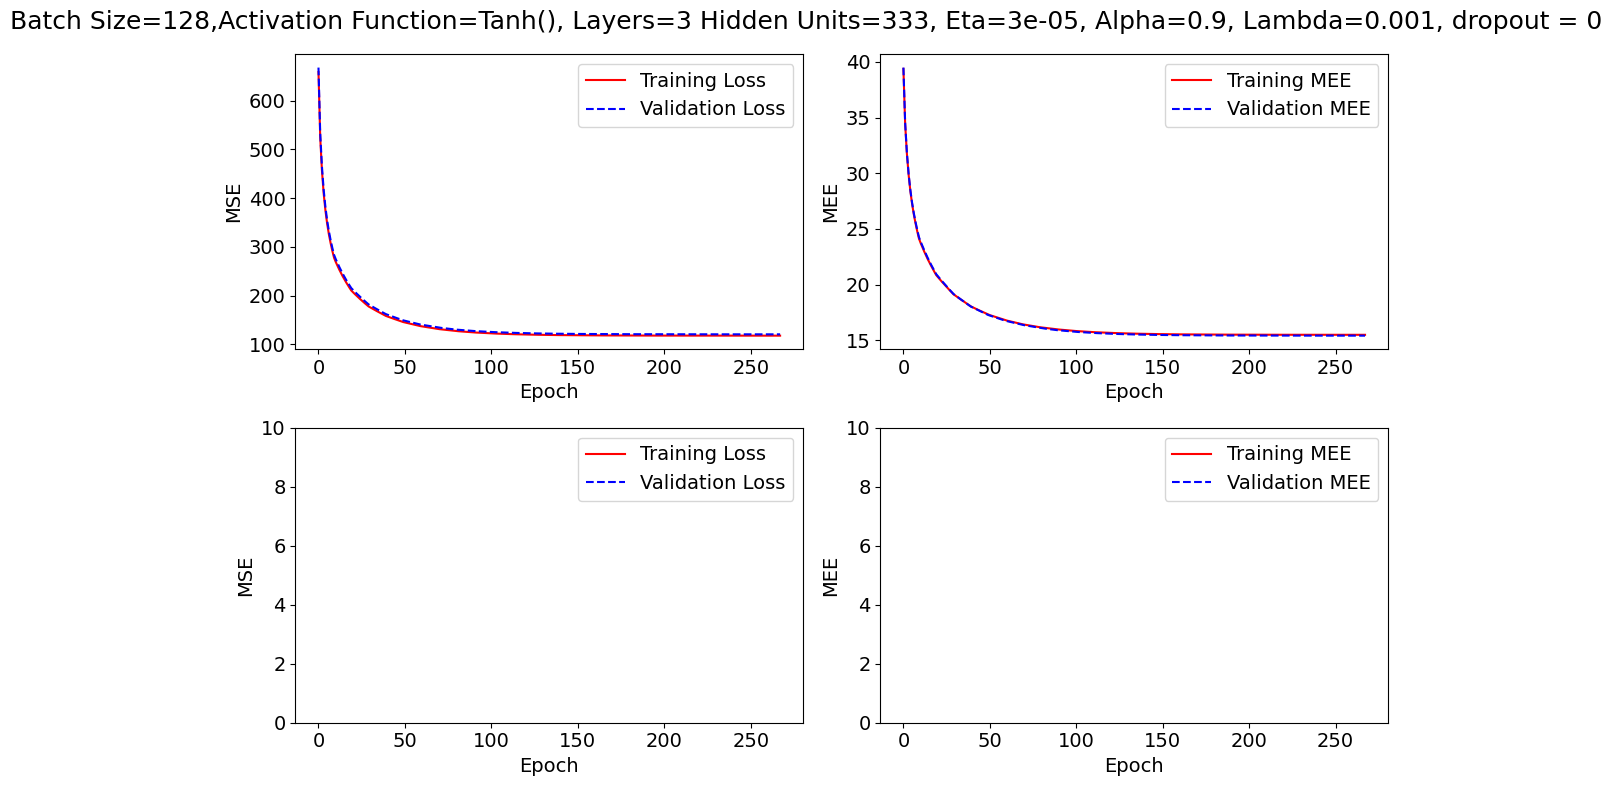

Avg of 1 initializations: Loss (train | test/val )= (117.8 +- 0.0 | 120.5 +- 0.0)- MEE (train | test/val ) = ( 15.48 +-  0.0 | 15.4 +- 0.0)


In [27]:
models, train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist = train_with_different_initializations(x_train=X_train,
               y_train=y_train,
               x_test=X_test,
               y_test=y_test,
               neuron_number=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               activation= best_hp[5],
               layers= best_hp[6],
               dropout= best_hp[7],
               factor= best_hp[8],
               lr_patience=best_hp[9],
               optimiz=optimiz,
               max_num_epochs=5000,
               plot_curves=True,
               return_history=True,
               N=1)

#save models to file
for index, model in enumerate(models):
    torch.save(model,f'saved_models/trained_nn{index}.pth')

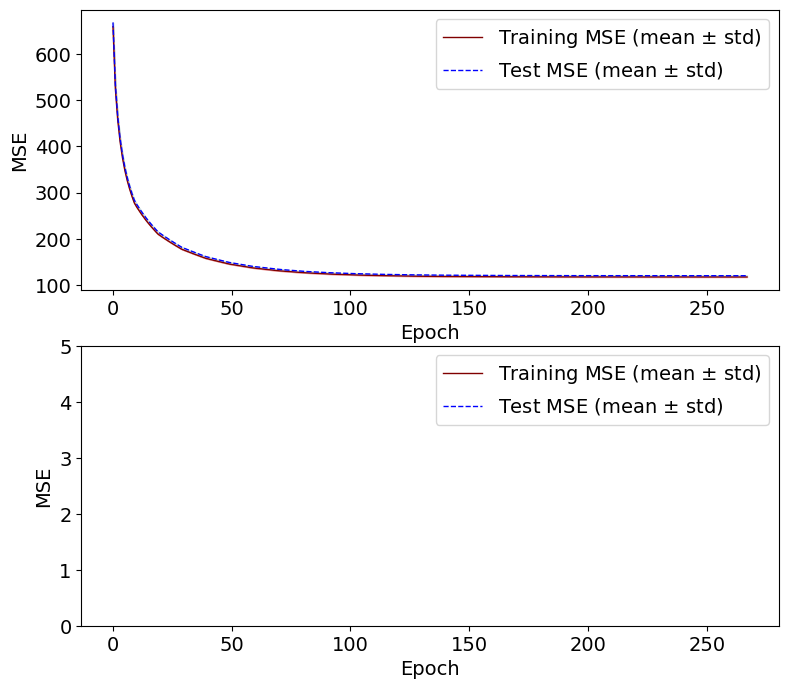

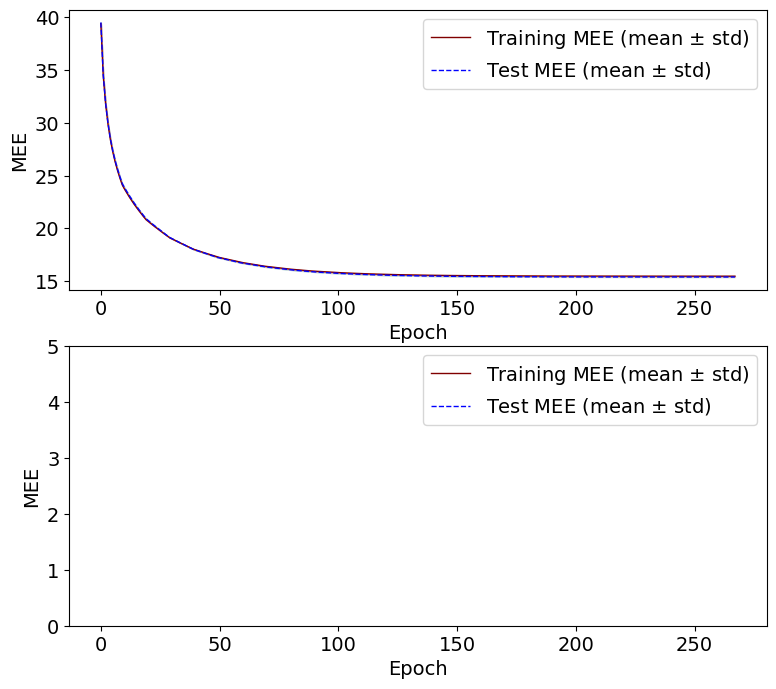

In [28]:
plot_mean_std(N=5,train_hist=train_losses_hist,test_hist=test_losses_hist,label='MSE')
plot_mean_std(N=5,train_hist=train_mees_hist,test_hist=test_mees_hist,label='MEE')